If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_ → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

# Problem 6.2. Anomaly Detection

In this problem, we will use machine learning techniques for anomaly detection to search for outliers in the data that pertains to the presence or absence of a vertebal / backbone disorder in a patient.

In [1]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import svm
from sklearn.utils import check_random_state

from nose.tools import assert_equal, assert_almost_equal, assert_is_instance, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

## Vertebral Column Data set
We shall be looking at the vertebral column data set for this problem. This data set has been taken from the [UCI Machine Learning repository](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column). The [vertebral column](https://en.wikipedia.org/wiki/Vertebral_column) or the backbone in humans consists of thirty three vertebrae that provide support to the body, but most importantly, houses the spinal cord which is the integral part of the [central nervous system](https://en.wikipedia.org/wiki/Central_nervous_system). 
The data set consists of data from 310 patients with six biomechanical features related to the pelvis and lumbar spine, namely, pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. Further information on these features, can be found in this [publication](https://pdfs.semanticscholar.org/a972/7a403fc0b6c9324be101295fd6a42577f3c2.pdf). In addition to these features, the data set contains information about the condition of the patient. There are 210 patients that were diagnosed with either [sponylolisthesis](https://en.wikipedia.org/wiki/Spondylolisthesis) or [disc herniation](https://en.wikipedia.org/wiki/Spinal_disc_herniation) were classified with "abnormal" vertebral condition, denoted by 'AB', while there are 100 patients who didn't show any signs of these diseases were classified as having "normal" vetebral condition, denoted by 'NO'.
Let's load the data set into a Pandas DataFrame.

In [2]:
vc_data = pd.read_csv('/home/data_scientist/data/misc/vert_column.csv', header=0, na_values='NA')
#vc_data = pd.read_csv('./data/vert_column.csv', header=0, na_values='NA') 
print(vc_data.head())

   PelvicIncidence  PelvicTilt  LumbarLordosisAngle  SacralSlope  \
0            63.03       22.55                39.61        40.48   
1            39.06       10.06                25.02        29.00   
2            68.83       22.22                50.09        46.61   
3            69.30       24.65                44.31        44.64   
4            49.71        9.65                28.32        40.06   

   PelvicRadius  SpondylolisthesisGrade PatientCondition  
0         98.67                   -0.25               AB  
1        114.41                    4.56               AB  
2        105.99                   -3.53               AB  
3        101.87                   11.21               AB  
4        108.17                    7.92               AB  


In [3]:
#Let's take a look at the statistical summary of our attributes
vc_data.describe()

,PelvicIncidence,PelvicTilt,LumbarLordosisAngle,SacralSlope,PelvicRadius,SpondylolisthesisGrade
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


## Standardization
PCA is a scale-dependent method. For example, if the range of one column is [-100, 100], while the that of another column is [-0.1, 0.1], PCA will place more weight on the feature with larger values. One way to avoid this is to standardize a data set by scaling each feature so that the individual features all look like Gausssian distributions with zero mean and unit variance.
For further detail, see Preprocessing data. The function scale provides a quick and easy way to perform this operation on a single array-like dataset.
Write a function named standardize() that uses sklearn.preprocessing.StandardScaler to scale each features so that they have zero mean and unit variance.

In [4]:
def standardize(df):
    '''
    Uses sklearn.preprocessing.StandardScaler to make each features look like
    a Gaussian with zero mean and unit variance.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A numpy array.
    '''
    
    # YOUR CODE HERE   
    # scale features
    std_scaler = preprocessing.StandardScaler()
    
    # preprocessing can only be used on arrays
    columns = []
    scaled = []
    for i in range(len(df.columns)):
        columns.append(np.array(df.ix[:, i]))
        scaled.append(std_scaler.fit_transform(columns[i].astype(float)))
    
    scaled = pd.DataFrame(scaled).T
    
    # add column names
    scaled.columns = df.columns
    scaled = scaled.as_matrix()
    
    return scaled


In [5]:
scaled = standardize(vc_data[vc_data.columns[:6]])

In [6]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero

scaled_t1 = standardize(df_t1)

assert_is_not(df_t1, scaled_t1)
assert_is_instance(scaled_t1, np.ndarray)
assert_array_almost_equal(
    scaled_t1.mean(axis=0),
    n_features * [0.0] # scaled data should have mean zero
    ) 
assert_array_almost_equal(
    scaled_t1.std(axis=0),
    [0., 1., 1., 1., 1.] # unit variance except for 1st feature
    )


## Principal Components Analysis
Write a function named fit_pca() that takes a pandas.DataFrame and uses sklearn.decomposition.PCA to fit a PCA model on all values of df.

In [7]:
def fit_pca(df, n_components):
    '''
    Uses sklearn.decomposition.PCA to fit a PCA model on "df" via fit using fit_transform()
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from delta.csv.
    n_components: An int. Number of principal components to keep.
    
    Returns
    -------
    a tuple of an sklearn.decomposition.pca.PCA instance and a numpy array containing the reduced data set
    '''
    
    # YOUR CODE HERE
    pca = PCA(n_components = n_components)
    pca.fit(df)
    
    # reduced data set
    reduced = pca.fit_transform(df)
    
    return pca, reduced

In [8]:
# using 4 components (randomly chosen)
n_components = 4
pca, reduced = fit_pca(scaled, n_components=n_components)

In [9]:

assert_almost_equal(pca.explained_variance_ratio_.sum(), 0.945664604953, 3)
assert_is_instance(reduced, np.ndarray)


t_pca, t_reduced = fit_pca(scaled_t1, 5)
assert_almost_equal(t_pca.explained_variance_ratio_.sum(), 1.0, 3)

## Calculating gamma and nu for oneClass SVM
Before we can create a [oneClass SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) model, we first need to calculate the tow of the important parameters required. A rule of thumb for deciding upon the value of gamma is that it should be a value between the inverse of the total instances (number of rows) and inverse of the features. For the purposes of this assignment: 
 $$ \gamma = \dfrac {1}{total  number  of  rows} $$

In [10]:
def get_gamma_nu(df, frac_of_outliers):
    '''
    Calculates the gamma and nu values to be used for the model. 
    Uses the inverse of the number of cases for calculating gamma.
    Uses the scikit learn recommended formula for calculating nu.
    
    Parameters
    ----------
    df: A pandas.DataFrame containing pca data.
    frac_of_outliers: A float. Expected Outlier Fraction.
    
    Returns
    -------
    A tuple of gamma and nu values
    '''
    # YOUR CODE HERE
    gamma = 1/(len(df))
    nu = frac_of_outliers * 0.95 + 0.05
    
    return gamma, nu

In [11]:

rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero


test1, test2 = get_gamma_nu(scaled,0.1)
assert_almost_equal(test1, 0.0032258064516129032, 5)
assert_almost_equal(test2, 0.14500000000000002, 3)

scaled_t1 = standardize(df_t1)
pca_t1,t_reduced = fit_pca(scaled_t1,5)
test3, test4 = get_gamma_nu(t_reduced, 0.2)
assert_almost_equal(test3, 0.25, 2)
assert_almost_equal(test4, 0.24, 2)

## OneClassSVM fitting and estimates
In the following code cell, write a function named get_svc that requires four parameters: df, kernel, frac_of_outliers and random_state. It returns a sklearn.svm.OneClassSVM Classifier instance.

In [12]:
def get_svc(df, kernel, frac_of_outliers, random_state):
    '''
    Takes in df, kernel and random state parameters, calculates nu & gamma using get_gamma_nu()
    and returns a One Class SVM classifier
    
    Parameters
    ----------
    df: A pandas.DataFrame. Standardized version of data.
    kernel: A string that specifies kernel to be used in SVM
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    An sklearn.svm.OneClassSVM
    '''
    # YOUR CODE HERE
    gamma, nuv = get_gamma_nu(df, frac_of_outliers)
    
    model = svm.OneClassSVM(nu = nuv, kernel = kernel, gamma = gamma, random_state = random_state)
    
    return model
    

In [13]:
t_ocSVM1 = get_svc(scaled_t1, 'rbf',0.1, check_random_state(0))
assert_is_instance(t_ocSVM1, svm.OneClassSVM)
assert_equal(t_ocSVM1.kernel, 'rbf')
assert_almost_equal(t_ocSVM1.gamma,0.25)

t_ocSVM2 = get_svc(scaled_t1, 'linear',0.1, check_random_state(0))
assert_is_instance(t_ocSVM2, svm.OneClassSVM)
assert_equal(t_ocSVM2.kernel, 'linear')
assert_almost_equal(t_ocSVM1.gamma,0.25)

## Fit and Predict
In the following code cell, write a function named fit_and_pred that makes classification predictions on the standardized version of the dataset, other than taking in the classifier instance as a parameter.


In [14]:
def fit_and_pred(svc, df):
    '''
    Fits the "svc" model on the standardized dataframe "df"
    Makes predictions on "df".
    
    Parameters
    ----------
    ocSVM: A sklearn classifier instance.
    df: A pandas.DataFrame. Standardized version of data.
    
    Returns
    -------
    A numpy array
    '''
    
    # YOUR CODE HERE
    svc.fit(df)
    preds = svc.predict(df)
    
    return preds



In [15]:
t_svc = get_svc(scaled_t1, 'rbf',0.1, check_random_state(0))
test_pred = fit_and_pred(t_svc, scaled_t1)
assert_array_equal(test_pred, np.array([ 1.,  1., -1., -1.]))

t_data = pd.DataFrame({
    'X0': np.arange(100), 
    'X1': np.arange(-25, 75),
    })
scaled_t2 =standardize(t_data) 
pca_t2 = fit_pca(scaled_t2, 2)
t2_svc = get_svc(scaled_t2, 'rbf',0.1, check_random_state(0))
test2_pred = fit_and_pred(t2_svc, scaled_t2)
assert_array_equal(test2_pred, np.array(
[-1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.]))

In [16]:
svc = get_svc(reduced,'rbf',0.1, check_random_state(0))
preds = fit_and_pred(svc, scaled)

## Identifying inliers and outliers
Next, we sort the inliers and outliers based on the prediction classes from the prediction results of the model we just fitted.

In [17]:
def get_pred_classes(preds):
    '''
    Retrieves prediction classes (outliers and inliers) from the data from the predictions
    made by the model.
    
    Parameters
    ----------
    preds: A numpy array, containing predictions.
    
    Returns
    -------
    A tuple of outliers and inliers that contain indices from the data set
    '''
    # YOUR CODE HERE
    inliers = np.where(preds == 1)
    outliers = np.where(preds == -1)
    
    return outliers, inliers

In [18]:
t_outliers, t_inliers = get_pred_classes(test_pred)
assert_array_equal(t_outliers, [[2,3]])
assert_array_equal(t_inliers, [[0, 1]])

t2_outliers, t2_inliers = get_pred_classes(test2_pred)
assert_array_equal(t2_outliers, [[ 0,  1,  2,  3,  4,  5,  6,  7, 92, 93, 94, 95, 96, 97, 98, 99]])
assert_array_equal(t2_inliers, [[ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]])

In [19]:
outliers, inliers = get_pred_classes(preds)

## Visualizing data along the first two principal components
Use maplotlib.plt to write a function named draw_scatter_plot() that creates a scatter plot of the data points (with inliers and outliers identified) along the first two principal components, as these components explain bulk of the variance in the data set, as can be observed by executing the code cell below. 


In [20]:
print("Explained Variance per PCA component\n", 35*'-')
for idx, val in enumerate(pca.explained_variance_ratio_):
    print('PCA component {0:2d}: {1:4.1f}%'.format(idx, val*100))
    
print(35*'-', '\nTotal Explained Variance (All PCA components: {0:4.1f}%\n'.format(
 sum(pca.explained_variance_ratio_[:]*100)))

print('Variance explained (First two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[:2]*100)))

print('Variance explained (Last two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[-2:]*100)))

Explained Variance per PCA component
 -----------------------------------
PCA component  0: 54.1%
PCA component  1: 19.9%
PCA component  2: 12.7%
PCA component  3:  7.9%
----------------------------------- 
Total Explained Variance (All PCA components: 94.6%

Variance explained (First two PCA components): 74.0%

Variance explained (Last two PCA components): 20.6%




When you run the following code for draw_scatter_plot, you should generate the following plot:
![](./images/PCA1vsPCA2.png)
It makes use of the parameters inliers and outliers (obtained from get_pred_classes() ) that contain indices or locations of rows that have been identified for the respective classes. These indices pertain to those rows in the dataframe "reduced" that contain the principal component values for all the four (n_components we arbitrarily chose) numerical features for each of 310 cases. 
``` python
>>> print(reduced)

[[-0.23836132 -0.89346458 -1.54747828  0.05457487]
 [-2.24645299 -0.40130963 -0.30289504  0.64297846]
 [ 0.27829698 -0.65388174 -1.00857292 -0.51419182]
 ..., 
 [-0.49758212  0.66527053 -0.36814074 -0.52018082]
 [-1.53121937 -0.40717078  0.2418938  -0.10213197]
 [-2.44753393 -0.0975671   0.52558415  0.10893291]]
 ```

For the scatterplot, we use the first principal component for the x-axis and the second principal component for the y-axis.

In [24]:
def draw_scatter_plot(inliers, outliers, reduced):
    '''
    Uses matplotlib.plt to plot a scatter plot with PCA1 on x-axis and PCA2 on the y-axis
    First plot the inliers on the scatter plot and then plot the outliers on the same graph.
    
    Parameters
    ----------
    inliers: array containing indices of the data points identified as inliers
    outliers: array containing indices of the data points identified as outliers
    reduced: dataFrame containing the principal components of our data (returned by pca_fit() )
    
    Returns
    -------
    A maplotlib.Axes instance
    '''
    # YOUR CODE HERE
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize = (10, 6))
    
    plt.plot(reduced[inliers,0], reduced[inliers,1], 'o', color='dodgerblue')
    plt.plot(reduced[outliers, 0], reduced[outliers,1], 'd', color='lightcoral')
    
    plt.legend(loc = 2)
    ax.set_xlim([-9, 4])
    ax.set_ylim([-4, 4])
    ax.set_xlabel('PCA Component 1 (54.1%)')
    ax.set_ylabel('PCA Component 2 (19.9%)')
    ax.set_title('Variance explained(First two PCA components): 74.0%')
    sns.despine(offset=10)

    return ax

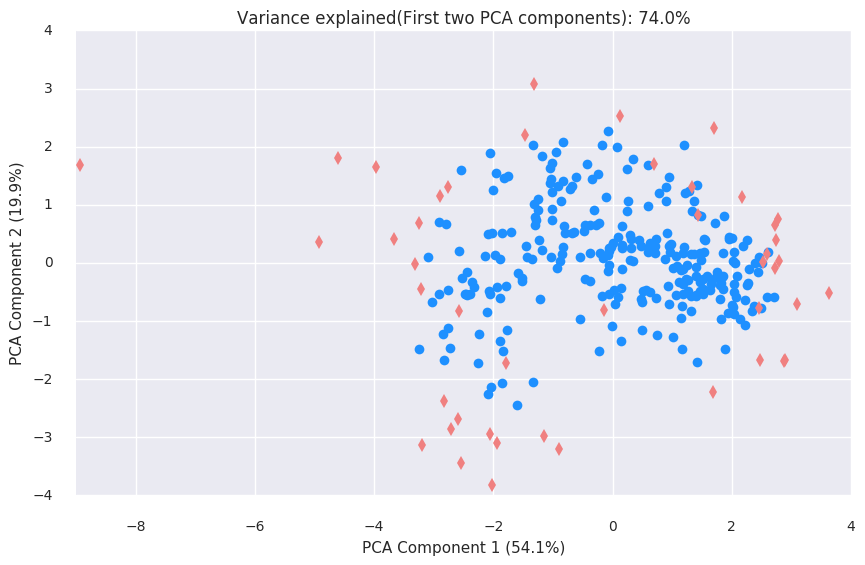

In [25]:
ax = draw_scatter_plot(inliers, outliers, reduced)


In [23]:
assert_is_instance(ax, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")
assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")

lines = ax.get_lines()
pts_lines= [l for l in lines]
#t_inliers = [l for l in lines if l.get_label()=='inliers'][0]
#t_outliers = [l for l in lines if l.get_label()=='outliers'][0]
t_xdata = pts_lines[0].get_xdata()
t_ydata = pts_lines[0].get_ydata()

t2_xdata = pts_lines[-1].get_xdata()
t2_ydata = pts_lines[-1].get_ydata()

assert_array_almost_equal(abs(t_xdata), [0.23836132], 3)
assert_array_almost_equal(abs(t_ydata), [0.89346458], 3)
assert_array_almost_equal(abs(t2_xdata), [2.59795974], 3)
assert_array_almost_equal(abs(t2_ydata), [0.1584883],3)